In [1]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from src.EuroSat_dataloaders import Test_Dataset_EuroSat,transformation_eurosat
from torchvision.datasets import EuroSAT
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torchvision.transforms import v2
from src.faithfulness.perturbation import eurosat_perturbation, thr_fc, thr_fc_bin,eurosat_perturbation_inverted
from src.faithfulness.silency_map import Silency_map_gen

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

## VGG-16

In [2]:

# model

vgg = torch.load("finished\\VGG16\\vgg_model.pth")
vgg.cuda()
for param in vgg.features.parameters():
        param.requires_grad = True
# add softmax
fc_ = list(vgg.classifier)
fc_.append(torch.nn.Softmax(dim=1))
vgg.classifier = torch.nn.Sequential(*fc_)
vgg.eval()

# dataset:

transforms = v2.Compose([
    v2.ToTensor(),
    v2.ToDtype(torch.float32),
    v2.Resize(224,antialias=None),
])
ds = EuroSAT("../EuroSat",transform=transforms,target_transform=transformation_eurosat,download=True)
ds_test = Test_Dataset_EuroSat(ds)

# target layer:
nr = 25
cam_type = "grad_cam_plus_plus"


vgg_plus = torch.load("finished\\VGG16\\vgg_model.pth")
vgg_plus.cuda()
for param in vgg_plus.features.parameters():
        param.requires_grad = True


target_layers = [vgg_plus.features[-2]]
targets = None

sil_gen = Silency_map_gen(vgg_plus, ds_test, target_layers)

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [3]:
DS_LABELS = ["AnnualCrop", "Forest", "HerbaceousVegetation", "Highway","Industrial","Pasture","PermanentCrop",
             "Residential", "River", "SeaLake"]

In [4]:
df_pred = pd.read_csv("finished\VGG16\\pred_test.csv")
ds_test = Test_Dataset_EuroSat(ds)
true_val = []
pred_val = []
for i in range(len(ds_test)):
    true_val.append(ds_test[i][1].argmax().item())
    pred_val.append(df_pred.iloc[i].argmax())

In [5]:
false_lst = []
for i in range(len(pred_val)):
    if true_val[i] != pred_val[i]:
        false_lst.append((true_val[i],pred_val[i],i))
print(false_lst)
print(len(false_lst))

[(8, 1, 34), (5, 0, 35), (3, 8, 36), (9, 6, 58), (1, 5, 69), (5, 2, 109), (6, 2, 110), (8, 3, 125), (8, 6, 129), (8, 3, 139), (3, 6, 182), (7, 2, 203), (1, 8, 230), (3, 6, 235), (3, 2, 247), (6, 2, 248), (2, 5, 255), (3, 8, 289), (5, 8, 292), (0, 8, 335), (0, 6, 402), (6, 4, 403), (8, 3, 420), (5, 9, 449), (0, 6, 457), (9, 8, 466), (3, 6, 485), (3, 6, 492), (6, 4, 514), (3, 8, 541), (6, 4, 577), (0, 9, 588), (6, 2, 599), (6, 3, 606), (0, 2, 620), (6, 0, 633), (8, 9, 636), (6, 0, 672), (4, 3, 691), (2, 1, 713), (0, 6, 736), (3, 8, 747), (3, 6, 769), (2, 6, 776), (5, 0, 821), (0, 8, 836), (8, 3, 847), (8, 3, 879), (1, 5, 888), (0, 6, 900), (3, 4, 928), (5, 0, 934), (6, 4, 936), (5, 3, 966), (5, 9, 986), (8, 0, 988), (3, 4, 993), (3, 8, 1006), (9, 6, 1012), (6, 4, 1058), (5, 8, 1072), (0, 2, 1074), (1, 9, 1078), (5, 1, 1109), (4, 7, 1129), (2, 6, 1146), (3, 2, 1150), (8, 3, 1160), (5, 6, 1181), (3, 6, 1194), (6, 7, 1230), (8, 3, 1235), (5, 8, 1236), (8, 3, 1244), (5, 2, 1268), (3, 8, 1276

In [6]:
lst_false = [(8, 1, 34), (5, 0, 35), (3, 8, 36), (9, 6, 58), (1, 5, 69), (5, 2, 109), (6, 2, 110), (8, 3, 125), (8, 6, 129), (8, 3, 139), (3, 6, 182), (7, 2, 203), (1, 8, 230), (3, 6, 235), (3, 2, 247), (6, 2, 248), (2, 5, 255), (3, 8, 289), (5, 8, 292), (0, 8, 335), (0, 6, 402), (6, 4, 403), (8, 3, 420), (5, 9, 449), (0, 6, 457), (9, 8, 466), (3, 6, 485), (3, 6, 492), (6, 4, 514), (3, 8, 541), (6, 4, 577), (0, 9, 588), (6, 2, 599), (6, 3, 606), (0, 2, 620), (6, 0, 633), (8, 9, 636), (6, 0, 672), (4, 3, 691), (2, 1, 713), (0, 6, 736), (3, 8, 747), (3, 6, 769), (2, 6, 776), (5, 0, 821), (0, 8, 836), (8, 3, 847), (8, 3, 879), (1, 5, 888), (0, 6, 900), (3, 4, 928), (5, 0, 934), (6, 4, 936), (5, 3, 966), (5, 9, 986), (8, 0, 988), (3, 4, 993), (3, 8, 1006), (9, 6, 1012), (6, 4, 1058), (5, 8, 1072), (0, 2, 1074), (1, 9, 1078), (5, 1, 1109), (4, 7, 1129), (2, 6, 1146), (3, 2, 1150), (8, 3, 1160), (5, 6, 1181), (3, 6, 1194), (6, 7, 1230), (8, 3, 1235), (5, 8, 1236), (8, 3, 1244), (5, 2, 1268), (3, 8, 1276), (5, 2, 1292), (5, 9, 1293), (2, 7, 1299), (5, 6, 1306), (7, 4, 1307), (5, 0, 1309), (4, 7, 1320), (3, 4, 1329), (3, 8, 1333), (3, 0, 1363), (3, 2, 1386), (6, 2, 1397), (0, 6, 1465), (3, 8, 1468), (0, 6, 1477), (5, 1, 1534), (3, 8, 1550), (3, 8, 1567), (5, 0, 1585), (6, 4, 1606), (5, 8, 1633), (3, 8, 1656), (1, 8, 1660), (2, 7, 1674), (5, 6, 1681), (3, 8, 1683), (2, 5, 1689), (5, 0, 1692), (5, 1, 1693), (0, 6, 1714), (3, 0, 1741), (5, 2, 1748), (3, 8, 1754), (0, 8, 1755), (6, 4, 1766), (5, 1, 1777), (5, 8, 1794), (8, 2, 1798), (4, 7, 1811), (3, 0, 1841), (3, 9, 1853), (8, 5, 1868), (0, 4, 1877), (5, 8, 1918), (1, 2, 1942), (3, 6, 1984), (8, 5, 1987), (8, 3, 2007), (8, 3, 2039), (4, 7, 2052), (3, 8, 2087), (8, 9, 2104), (8, 0, 2105), (5, 0, 2110), (0, 6, 2134), (6, 2, 2150), (5, 4, 2163), (8, 3, 2176), (2, 6, 2183), (1, 2, 2184), (8, 3, 2193), (6, 2, 2198), (6, 3, 2199), (6, 0, 2212), (0, 9, 2239), (6, 0, 2281), (6, 3, 2285), (5, 7, 2286), (2, 6, 2321), (3, 6, 2330), (3, 0, 2333), (2, 6, 2340), (5, 8, 2357), (3, 6, 2368), (5, 2, 2381), (0, 8, 2382), (6, 4, 2396), (5, 1, 2420), (5, 1, 2430), (3, 7, 2445), (3, 0, 2452), (3, 8, 2506), (4, 7, 2573), (0, 5, 2603), (3, 6, 2619), (0, 9, 2649), (0, 9, 2654), (0, 6, 2656), (6, 2, 2691), (6, 3, 2694), (8, 3, 2697)]

C:\Users\nikos\AppData\Local\Temp\ipykernel_23304\976322739.py:3: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3575.)
  cam_image = show_cam_on_image(torch.transpose(baseline_im.T,1,0).numpy(), baseline_sl, use_rgb=True)


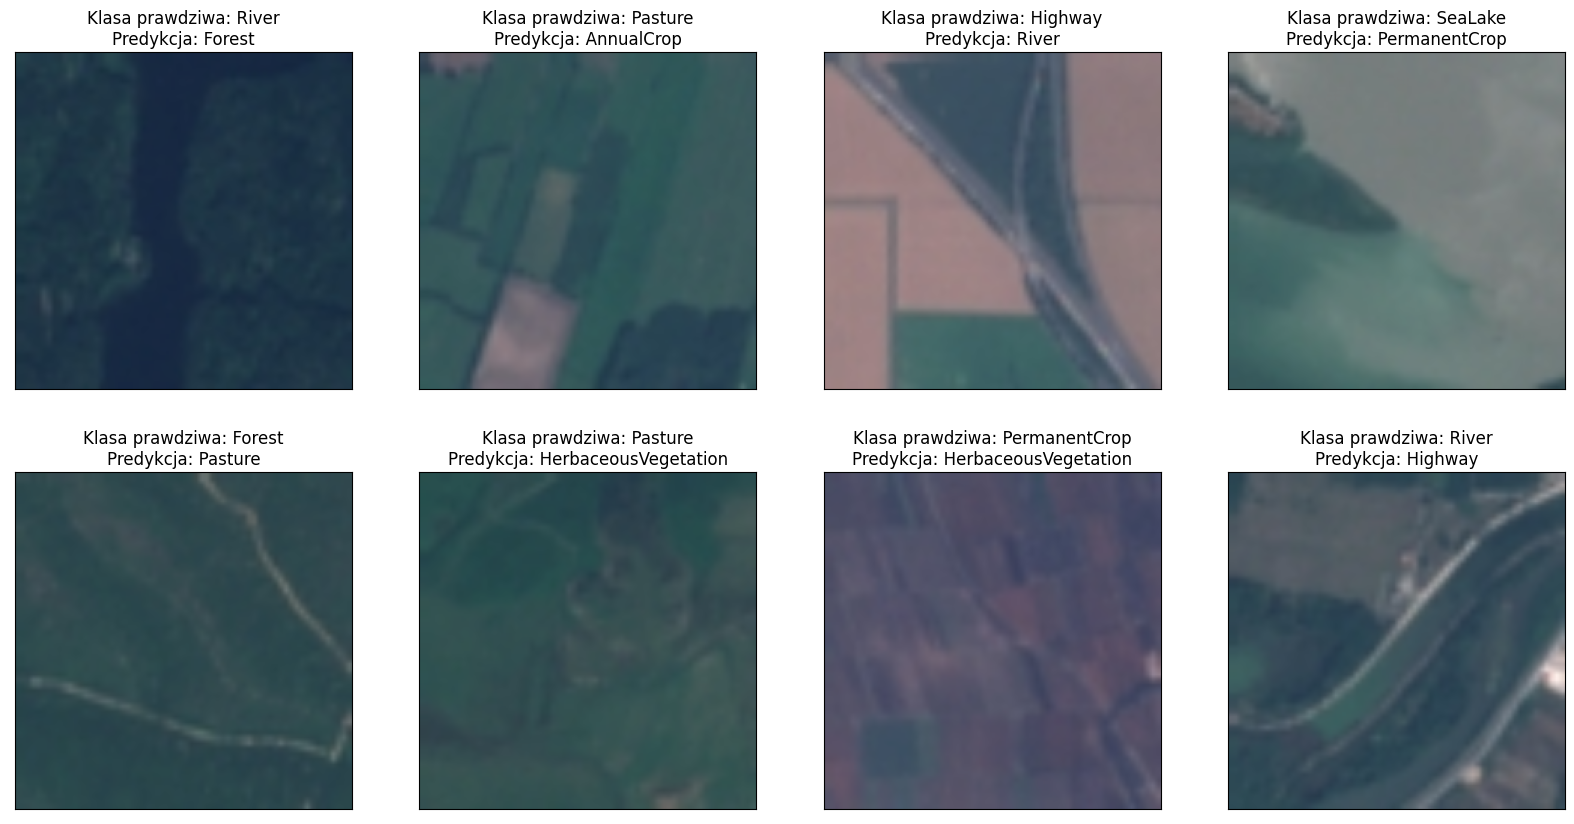

In [7]:
baseline_im = torch.zeros(sil_gen.ds[0][0].shape)
baseline_sl = sil_gen.get_silency_map_input(baseline_im,cam_type=cam_type)
cam_image = show_cam_on_image(torch.transpose(baseline_im.T,1,0).numpy(), baseline_sl, use_rgb=True)
fig, ax = plt.subplots(2,4)
fig.set_size_inches(20,10)

for i,j,temp in zip([0,0,0,0,1,1,1,1],[0,1,2,3,0,1,2,3],lst_false):
    ax[i,j].imshow(torch.transpose((sil_gen.ds[temp[2]][0].T.cpu()+1)/2,1,0).numpy())
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])
    ax[i,j].set_title(f"Klasa prawdziwa: {DS_LABELS[temp[0]]}\nPredykcja: {DS_LABELS[temp[1]]}")

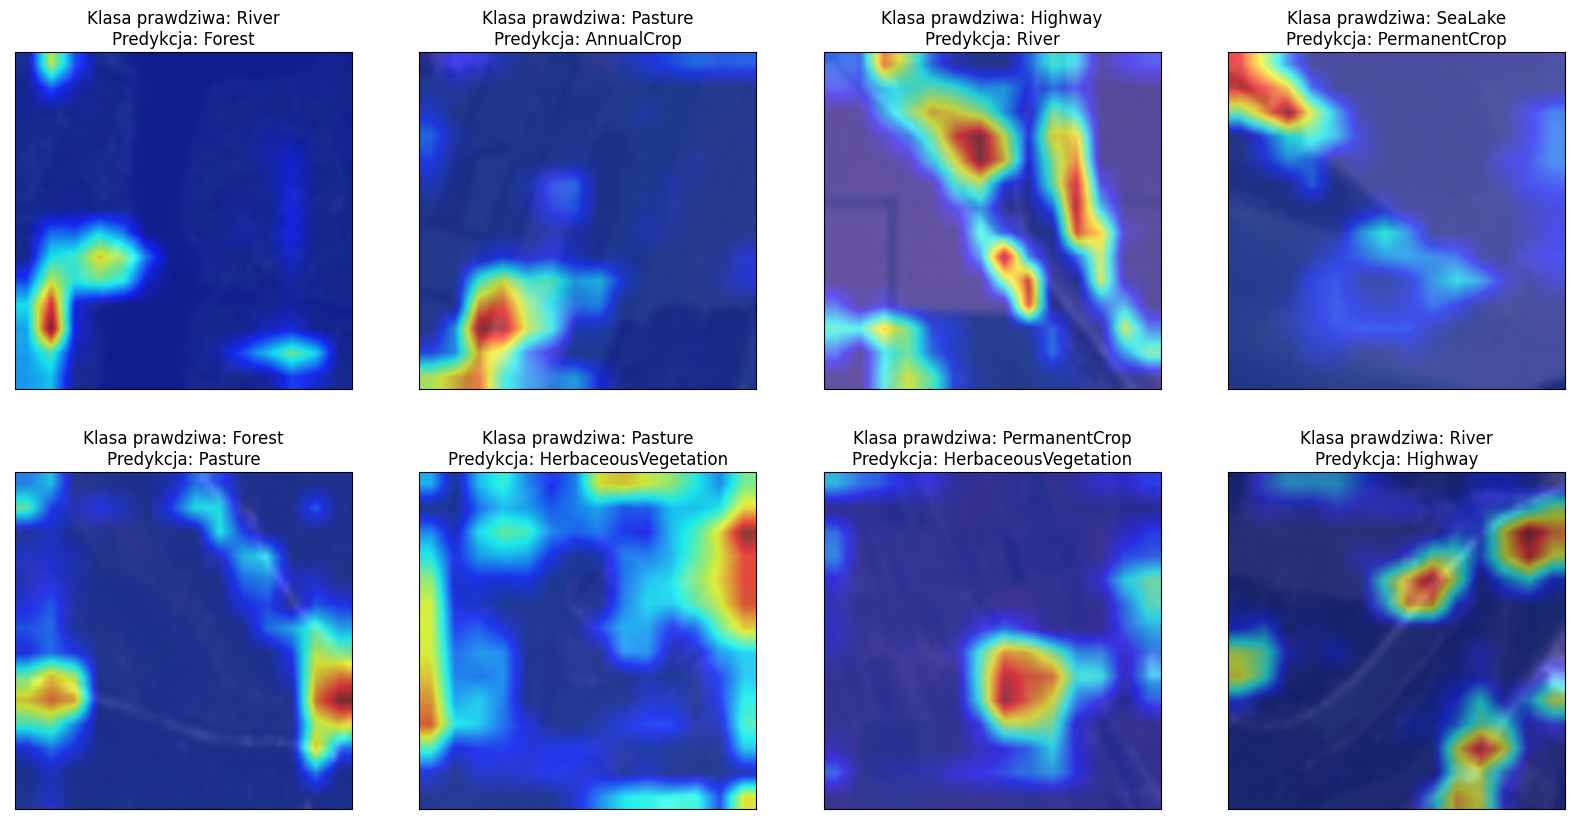

In [8]:
fig, ax = plt.subplots(2,4)
fig.set_size_inches(20,10)

for i,j,temp in zip([0,0,0,0,1,1,1,1],[0,1,2,3,0,1,2,3],lst_false):
    sl , pert_sl, pred = sil_gen.get_pair_sailency(temp[2],return_pred = True)
    cam_image = show_cam_on_image(torch.transpose((sil_gen.ds[temp[2]][0].T.cpu()+1)/2,1,0).numpy(), sl, use_rgb=True)
    ax[i,j].imshow(cam_image)
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])
    ax[i,j].set_title(f"Klasa prawdziwa: {DS_LABELS[temp[0]]}\nPredykcja: {DS_LABELS[temp[1]]}")

## ResNet50

In [9]:

resnet50 = torch.load("finished\\ResNet50_new\\resnet50_model.pth")
resnet50.cuda()

# add softmax

fc_ = list(resnet50.fc)
fc_.append(torch.nn.Softmax(dim=1))
resnet50.fc = torch.nn.Sequential(*fc_)
resnet50.eval()

resnet50_plus = torch.load("finished\\ResNet50_new\\resnet50_model.pth")
resnet50_plus.cuda()
resnet50_plus.eval()

# dataset:
transforms = v2.Compose([
    v2.ToTensor(),
    v2.ToDtype(torch.float32),
    v2.Resize(224,antialias=None),
])
ds = EuroSAT("../EuroSat",transform=transforms,target_transform=transformation_eurosat,download=False)
ds_test = Test_Dataset_EuroSat(ds)

# target layer:
cam_type = "grad_cam_plus_plus"
target_layers = [resnet50_plus.layer4[-1]]
sil_gen = Silency_map_gen(resnet50_plus, ds_test, target_layers)

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [10]:
DS_LABELS = ["AnnualCrop", "Forest", "HerbaceousVegetation", "Highway","Industrial","Pasture","PermanentCrop",
             "Residential", "River", "SeaLake"]

In [11]:
df_pred = pd.read_csv("finished\ResNet50_new\\pred_test.csv")
ds_test = Test_Dataset_EuroSat(ds)
true_val = []
pred_val = []
for i in range(len(ds_test)):
    true_val.append(ds_test[i][1].argmax().item())
    pred_val.append(df_pred.iloc[i].argmax())

In [12]:
false_lst = []
for i in range(len(pred_val)):
    if true_val[i] != pred_val[i]:
        false_lst.append((true_val[i],pred_val[i],i))
print(false_lst)
print(len(false_lst))

[(3, 7, 5), (0, 9, 8), (0, 6, 183), (0, 6, 331), (9, 8, 466), (1, 2, 490), (6, 2, 524), (0, 2, 620), (6, 5, 633), (8, 9, 636), (6, 0, 672), (0, 6, 736), (8, 3, 761), (2, 6, 776), (6, 2, 778), (8, 2, 792), (5, 2, 860), (2, 4, 881), (0, 6, 900), (6, 0, 902), (5, 6, 934), (2, 9, 1015), (6, 2, 1023), (5, 1, 1109), (3, 4, 1159), (8, 0, 1160), (2, 6, 1190), (6, 2, 1230), (5, 8, 1236), (5, 2, 1268), (6, 0, 1284), (5, 9, 1293), (5, 2, 1303), (6, 3, 1305), (0, 6, 1332), (2, 6, 1366), (7, 4, 1509), (6, 0, 1526), (6, 2, 1565), (5, 0, 1585), (0, 6, 1634), (5, 0, 1692), (5, 1, 1693), (5, 0, 1748), (6, 2, 1781), (2, 6, 1825), (0, 6, 1843), (0, 6, 1877), (5, 1, 1920), (5, 8, 1925), (2, 6, 1974), (2, 0, 2095), (1, 2, 2118), (0, 6, 2134), (4, 6, 2140), (2, 6, 2190), (0, 5, 2239), (6, 0, 2281), (0, 9, 2301), (8, 3, 2311), (2, 6, 2321), (3, 0, 2333), (6, 2, 2339), (2, 6, 2340), (5, 1, 2381), (6, 3, 2396), (5, 1, 2420), (2, 5, 2431), (3, 2, 2532), (4, 7, 2541), (0, 6, 2545), (0, 5, 2569), (0, 5, 2626), (6

In [13]:
lst_false = [(3, 7, 5), (0, 9, 8), (0, 6, 183), (0, 6, 331), (9, 8, 466), (1, 2, 490), (6, 2, 524), (0, 2, 620), (6, 5, 633), (8, 9, 636), (6, 0, 672), (0, 6, 736), (8, 3, 761), (2, 6, 776), (6, 2, 778), (8, 2, 792), (5, 2, 860), (2, 4, 881), (0, 6, 900), (6, 0, 902), (5, 6, 934), (2, 9, 1015), (6, 2, 1023), (5, 1, 1109), (3, 4, 1159), (8, 0, 1160), (2, 6, 1190), (6, 2, 1230), (5, 8, 1236), (5, 2, 1268), (6, 0, 1284), (5, 9, 1293), (5, 2, 1303), (6, 3, 1305), (0, 6, 1332), (2, 6, 1366), (7, 4, 1509), (6, 0, 1526), (6, 2, 1565), (5, 0, 1585), (0, 6, 1634), (5, 0, 1692), (5, 1, 1693), (5, 0, 1748), (6, 2, 1781), (2, 6, 1825), (0, 6, 1843), (0, 6, 1877), (5, 1, 1920), (5, 8, 1925), (2, 6, 1974), (2, 0, 2095), (1, 2, 2118), (0, 6, 2134), (4, 6, 2140), (2, 6, 2190), (0, 5, 2239), (6, 0, 2281), (0, 9, 2301), (8, 3, 2311), (2, 6, 2321), (3, 0, 2333), (6, 2, 2339), (2, 6, 2340), (5, 1, 2381), (6, 3, 2396), (5, 1, 2420), (2, 5, 2431), (3, 2, 2532), (4, 7, 2541), (0, 6, 2545), (0, 5, 2569), (0, 5, 2626), (6, 2, 2691), (6, 0, 2694)]

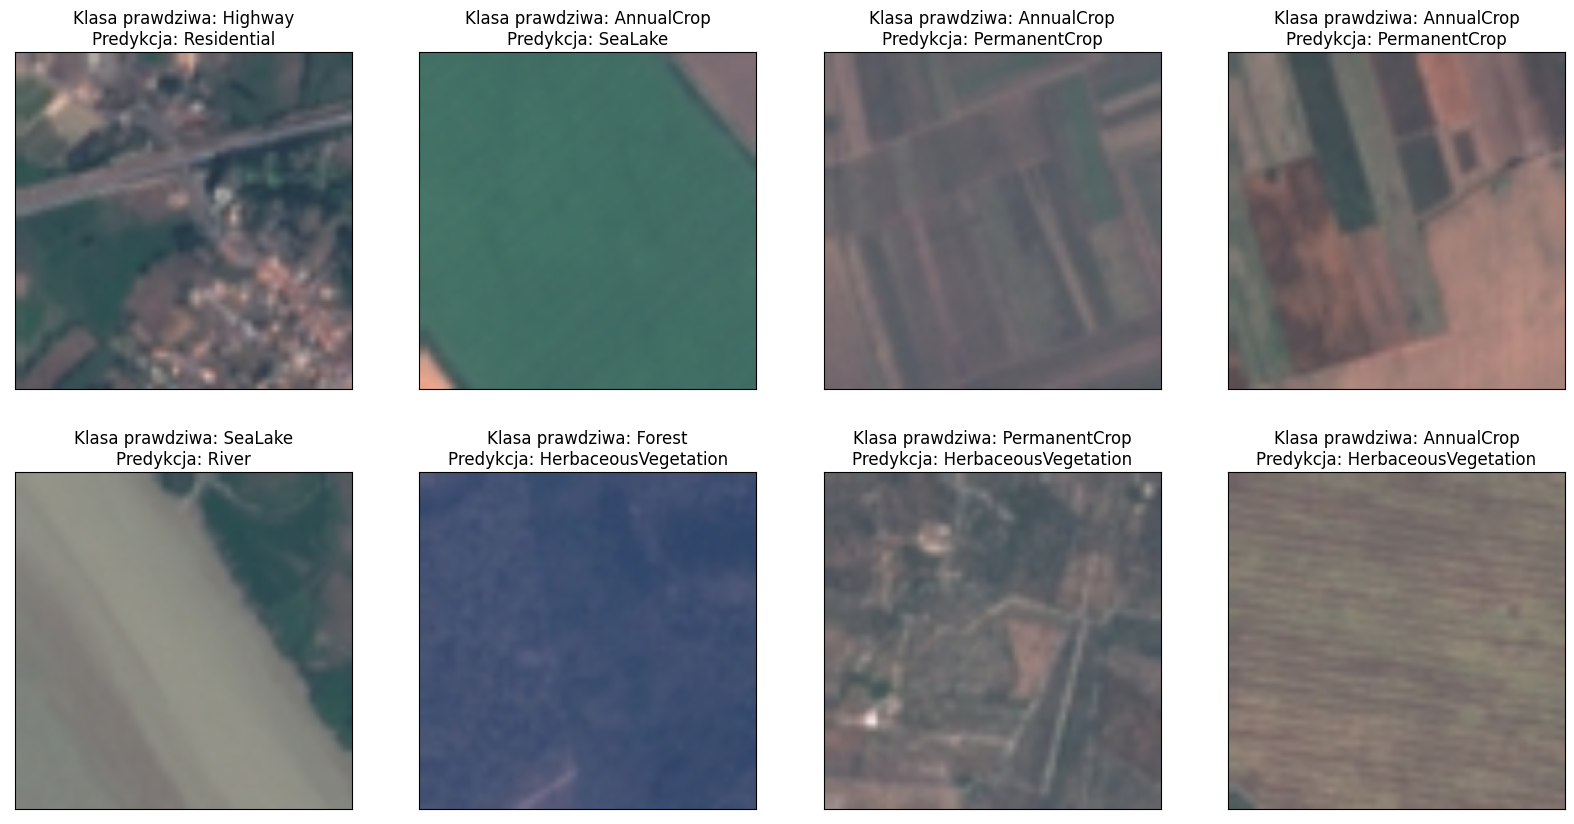

In [14]:
fig, ax = plt.subplots(2,4)
fig.set_size_inches(20,10)

for i,j,temp in zip([0,0,0,0,1,1,1,1],[0,1,2,3,0,1,2,3],lst_false):
    ax[i,j].imshow(torch.transpose((sil_gen.ds[temp[2]][0].T.cpu()+1)/2,1,0).numpy())
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])
    ax[i,j].set_title(f"Klasa prawdziwa: {DS_LABELS[temp[0]]}\nPredykcja: {DS_LABELS[temp[1]]}")

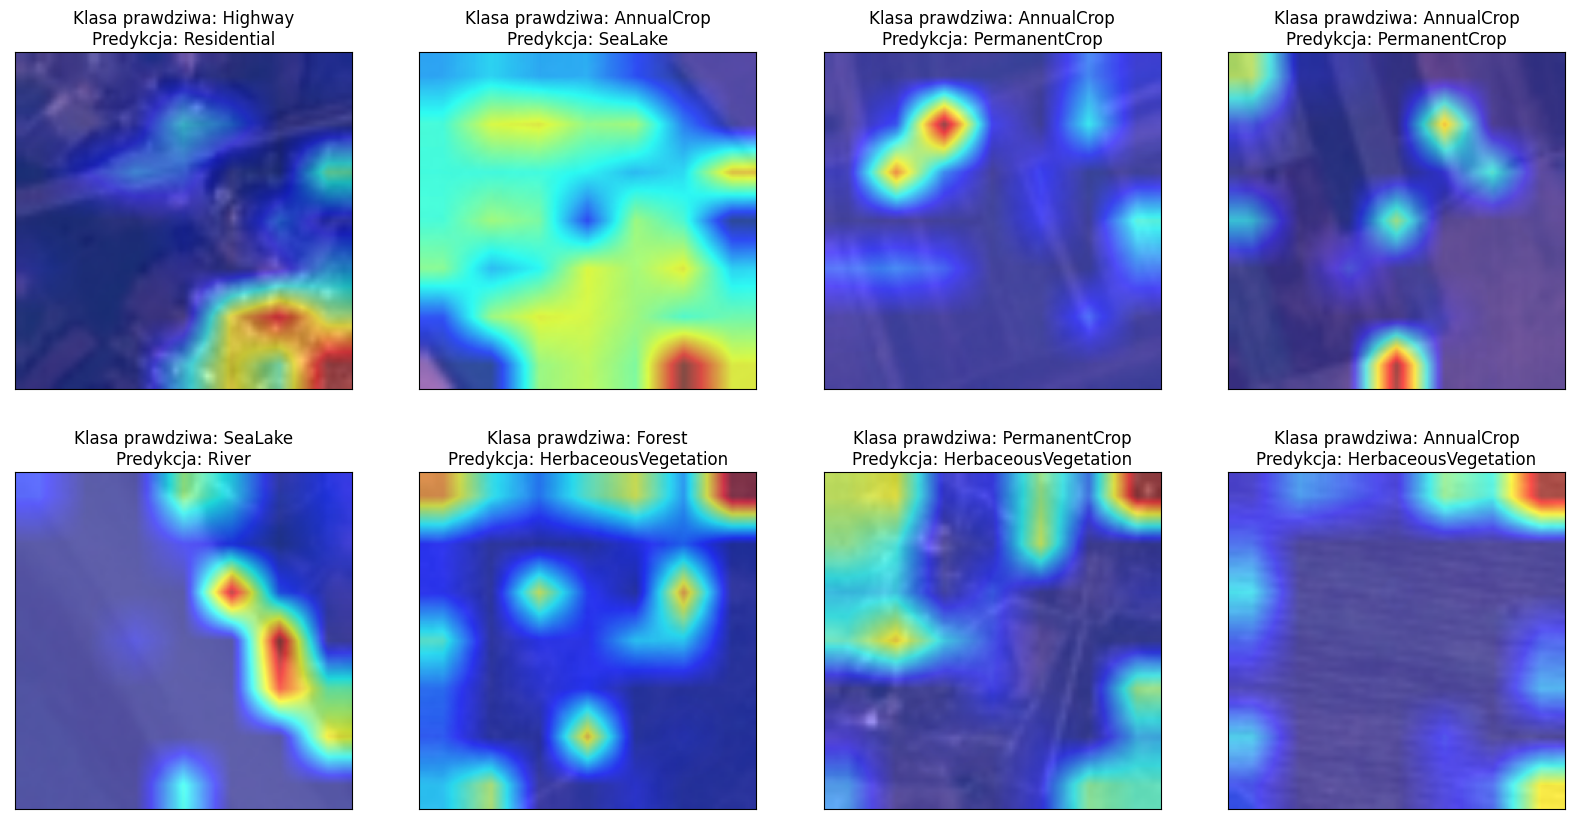

In [15]:
fig, ax = plt.subplots(2,4)
fig.set_size_inches(20,10)

for i,j,temp in zip([0,0,0,0,1,1,1,1],[0,1,2,3,0,1,2,3],lst_false):
    sl , pert_sl, pred = sil_gen.get_pair_sailency(temp[2],return_pred = True)
    cam_image = show_cam_on_image(torch.transpose((sil_gen.ds[temp[2]][0].T.cpu()+1)/2,1,0).numpy(), sl, use_rgb=True)
    ax[i,j].imshow(cam_image)
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])
    ax[i,j].set_title(f"Klasa prawdziwa: {DS_LABELS[temp[0]]}\nPredykcja: {DS_LABELS[temp[1]]}")